In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.dm import DFTemporalDataModule
from src.module import UnetTemporalDF

In [3]:
import torch 

checkpoint = 'checkpoints/unet_df_temp_indexes-val_metric=7900.86279-epoch=218.ckpt'

hparams = {
	'encoder': 'resnet18',
    'pretrained': 'imagenet',
    'in_channels_s1': 2,
    'in_channels_s2': 8,
    "seq_len": 12
}

# module = UNet.load_from_checkpoint(checkpoint)
# module.hparams

state_dict = torch.load(checkpoint)['state_dict']
module = UnetTemporalDF(hparams)
module.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
# dm = RGBTemporalDataModule()
dm = DFTemporalDataModule(s2_bands=(2,1,0,7,9), use_ndvi=True, use_ndwi=True, use_clouds=True)
dm.setup()

train: 8689
test: 2773


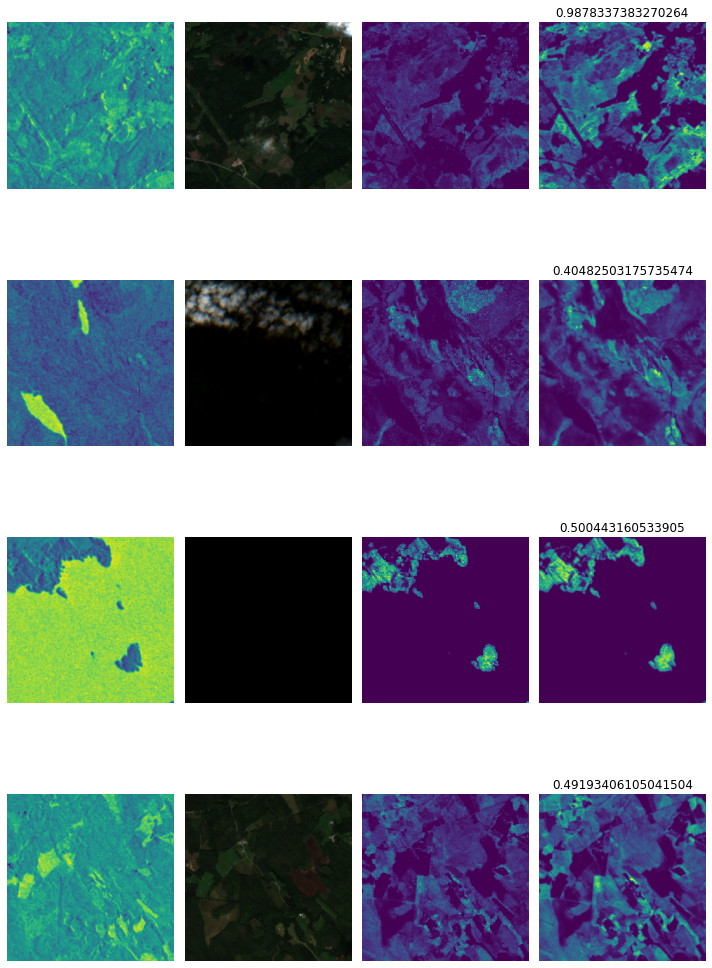

In [5]:
import torch 
import matplotlib.pyplot as plt 

dl = dm.train_dataloader(batch_size=4)
s1, s2, labels = next(iter(dl))

module.cpu()
preds = module.predict(s1, s2)

fig, ax = plt.subplots(4, 4, figsize=(10, 15))
for i in range(4):
	ax[i, 0].imshow(s1[i][-1][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i][-1][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(labels[i])
	ax[i, 2].axis('off')
	ax[i, 3].imshow(preds[i])
	ax[i, 3].axis('off')
	ax[i, 3].set_title(torch.sqrt(
            torch.sum((preds[i] - labels[i])**2)).item())
plt.tight_layout()
plt.show()

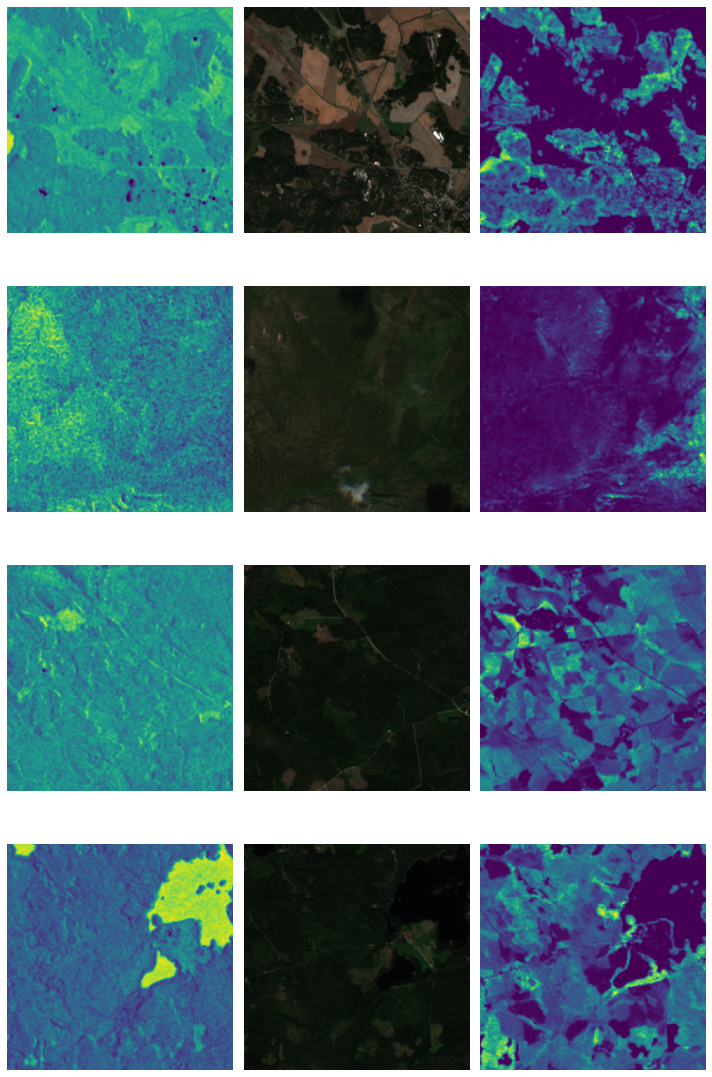

In [6]:
dl = dm.test_dataloader(batch_size=4)
s1, s2, _ = next(iter(dl))

module.cpu()
preds = module.predict(s1, s2)

fig, ax = plt.subplots(4, 3, figsize=(10, 16))
for i in range(4):
	ax[i, 0].imshow(s1[i][-1][0])
	ax[i, 0].axis('off')
	ax[i, 1].imshow(s2[i][-1][:3,...].permute(1, 2, 0))
	ax[i, 1].axis('off')
	ax[i, 2].imshow(preds[i])
	ax[i, 2].axis('off')
plt.tight_layout()
plt.show()

In [7]:
from tqdm import tqdm 
from skimage.io import imsave

dl = dm.test_dataloader(batch_size=16)
module.cuda(1)

for s1, s2, chip_ids in tqdm(dl):
	preds = module.predict(s1.cuda(1), s2.cuda(1))
	# preds = preds*(dm.ds_test.max - dm.ds_test.min) + dm.ds_test.min
	# preds = preds*dm.ds_test.std + dm.ds_test.mean
	preds = preds*dm.ds_test.max
	for chip_id, pred in zip(chip_ids, preds.cpu().numpy()):
		imsave(f'./submission/{chip_id}_agbm.tif', pred)

100%|██████████| 174/174 [04:40<00:00,  1.61s/it]


In [8]:
import glob 

files = glob.glob('./submission/*.tif')
assert len(files) == 2773

In [9]:
# zip folder 

import shutil
shutil.make_archive('submission', 'zip', './submission')

'/home/juan/Desktop/competis/TheBioMassters/submission.zip'

In [10]:
import rasterio as rio
import numpy as np

ix = np.random.randint(0, len(files))
ds = rio.open(files[ix])

ds.indexes, ds.shape, ds.count

/home/juan/miniconda3/lib/python3.8/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


((1,), (256, 256), 1)

In [11]:
x = ds.read(1)

x.shape, x.dtype, x.min(), x.max()

((256, 256), dtype('float32'), 0.012973611, 263.42102)

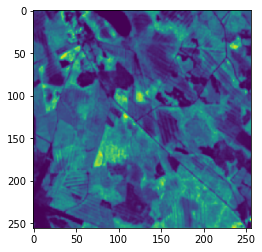

In [12]:
plt.imshow(x)
plt.show()